### Setup

In [1]:
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import os
import torch
import transformer_lens
import random
import plotly.express as px

from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import generate_example, parse_example, GraphDataset
from utils import *
from interp_utils import *

/media/victor/F8D25071D25035DA/Alingment/GraphPlanning/planning-in-transformers/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model Training

Loading contents from file...


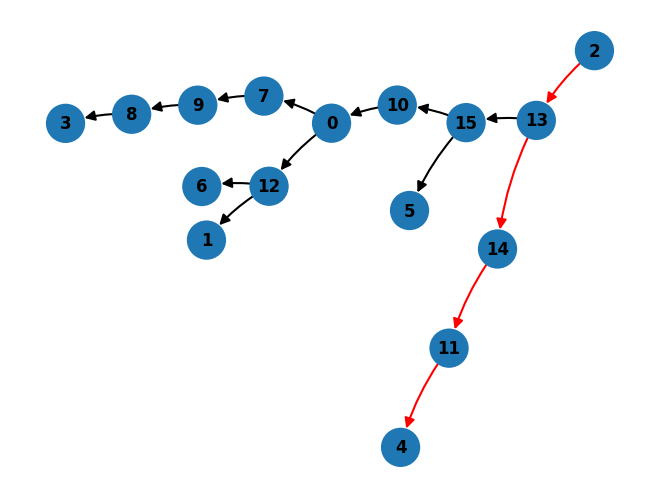

In [2]:
n_examples = 172_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)
train_loader, test_loader = get_loaders(dataset, 32)

In [3]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


In [4]:
model_name="model.pt"

In [5]:
# Load in the model if weights are in the directory, else train new model
if os.path.exists(model_name):
    model.load_state_dict(torch.load(model_name))
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), model_name)

In [6]:
start_seed = 250_000
num_samples = 100

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 99.0000%
random: 100.0000%


In [7]:
test_graph = generate_example(n_states, 1231, order="random")
labels, cache = get_example_cache(test_graph, model, dataset)

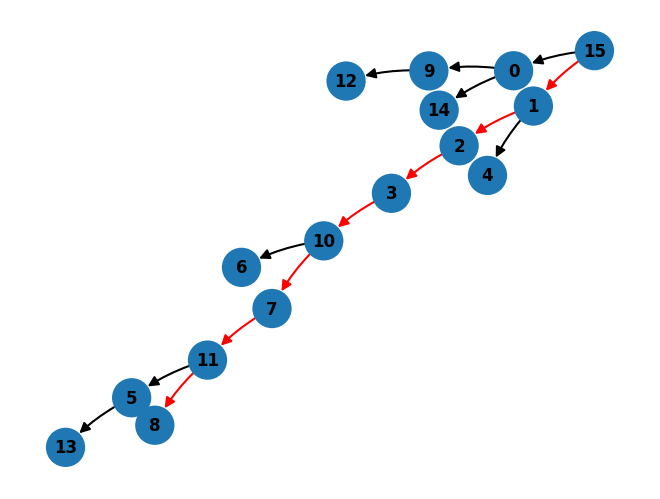

In [8]:
parse_example(test_graph)

In [9]:
def ablation_hook(
            resid_pre,
            hook):
        # Each HookPoint has a name attribute giving the name of the hook.
        resid_pre = resid_pre*0
        return resid_pre

### Useful functions

In [10]:
def logit_lens_hook(pred, model,dataset, lenses=None):
    # Get labels and cache

    labels, _ = get_example_cache(pred, model, dataset)
    tokens = torch.from_numpy(dataset.tokenize(pred)[0:-1]).cuda()
    _, cache = model.run_with_cache(tokens)
    # Calculate end idx of the labels
    end = num_last(labels, ",")
    # Get the logit lens for each layer's resid_post
    outs = []
    for layer in range(1, model.cfg.n_layers+1):
        if layer < model.cfg.n_layers:
            act_name = tl_util.get_act_name("normalized", layer, "ln1")
        else:
            act_name = "ln_final.hook_normalized"
        res_stream = cache[act_name][0]
        if lenses is not None:
            out_proj = res_stream @ lenses[act_name]
        else:
            out_proj = res_stream @ model.W_U
        out_proj = out_proj.argmax(-1)
        lens_out = [dataset.idx2tokens[i] for i in out_proj]
        outs.append([f"Layer {layer} LL"] + lens_out[47:end])
    # Plot data
    header = dict(values=["Current Input"] + labels[47:end])
    rows = dict(values=np.array(outs).T.tolist())
    table = go.Table(header=header, cells=rows)
    layout = go.Layout(width=1000, height=700)
    figure = go.Figure(data=[table], layout=layout)
    figure.show()

In [11]:
def logit_lens_hook_layer(pred, model,dataset,layer, lenses=None,layer_type="ln1"):
    # Get labels and cache

    labels, _ = get_example_cache(pred, model, dataset)
    tokens = torch.from_numpy(dataset.tokenize(pred)[0:-1]).cuda()
    _, cache = model.run_with_cache(tokens)
    # Calculate end idx of the labels
    end = num_last(labels, ",")
    # Get the logit lens for each layer's resid_post
    outs = []
    
    if layer < model.cfg.n_layers:
        act_name = tl_util.get_act_name("normalized", layer, layer_type)
    else:
        act_name = "ln_final.hook_normalized"
    res_stream = cache[act_name][0]
    if lenses is not None:
        out_proj = res_stream @ lenses[act_name]
    else:
        out_proj = res_stream @ model.W_U
        out_proj = out_proj
    # Plot data
    return out_proj


In [12]:
def logit_lens_correct_probs_hook(pred, model, dataset, position, lenses=None):
    # Get labels and cache
    labels, _ = get_example_cache(pred, model, dataset)
    tokens = torch.from_numpy(dataset.tokenize(pred)[0:-1]).cuda()
    _, cache = model.run_with_cache(tokens)
    probs = []
    correct_token = labels[position+1]
    correct_token_idx = dataset.tokens2idx[correct_token]
    for layer in range(1, model.cfg.n_layers+1):
        if layer < model.cfg.n_layers:
            act_name = tl_util.get_act_name("normalized", layer, "ln1")
        else:
            act_name = "ln_final.hook_normalized"
        res_stream = cache[act_name][0]
        if lenses is not None:
            out_proj = res_stream @ lenses[act_name]
        else:
            out_proj = res_stream @ model.W_U
            out_proj = out_proj.softmax(-1)
        probs.append( out_proj[position, correct_token_idx].item() )
    # Plot data
    return probs, correct_token ,labels

### Logit lens experiments 

In [13]:
model.reset_hooks()

In [14]:
model.reset_hooks()
temp_hook_fn = ablation_hook

#model.blocks[5].hook_resid_mid.add_hook(temp_hook_fn)
#model.blocks[4].hook_resid_mid.add_hook(temp_hook_fn)
model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].hook_resid_mid.add_hook(temp_hook_fn)
#model.blocks[5].hook_attn_out.add_hook(temp_hook_fn)
#model.blocks[4].hook_attn_out.add_hook(temp_hook_fn)

### Tuned lens

In [15]:
model.reset_hooks()
temp_hook_fn = ablation_hook
model.blocks[4].hook_resid_post.add_hook(temp_hook_fn)

In [16]:
start_seed = 250_000
num_samples = 100

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 99.0000%
random: 100.0000%


In [17]:
model.reset_hooks()

In [38]:
def eval_model_hooks(model, dataset, test_graph, add_hooks_fn=None):
    # Prepare model
    model.eval()
    if add_hooks_fn is not None:
        add_hooks_fn(model)
    
    # Initialize counters
    test_graph_tokens = dataset.tokenize(test_graph)
    start_idx = np.where(test_graph_tokens == dataset.start_token)[0].item() + 2
    curr_idx = start_idx

    flag = False
    while not flag and curr_idx < dataset.max_seq_length - 1:
        # Convert to pytorch
        input_tokens = torch.from_numpy(test_graph_tokens).to(torch.long).cuda()
        input_tokens[curr_idx:] = 0
        input_tokens = input_tokens.unsqueeze(0)[:, :-1]
        # Run model
        with torch.no_grad():
            outputs = model(input_tokens).argmax(-1)
            pred = outputs[0, curr_idx-1]
            test_graph_tokens[curr_idx] = pred.item()
            if pred.item() == dataset.pad_token:  # Check if we reached the goal
                flag = True
        curr_idx += 1

    final_path = dataset.untokenize(test_graph_tokens[:curr_idx])
    return final_path, test_graph == final_path

In [61]:
start_seed = 250_000  
num_samples = 100
accuracy_percentages_base=[]
for i in range(1,n_states):
    X, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=[utils.get_act_name("v", i, "attn") for i in range(0, 6)],
        n_samples=num_samples,path_length=i, order="forward"

    )
    total_correct = 0
    for graph in graphs:
          pred, correct = eval_model(model, dataset, graph)
          if correct:
            total_correct += 1   
    accuracy=100* total_correct / num_samples
    accuracy_percentages_base.append(accuracy)
    print(f"distance_{i}: {accuracy:.4f}%")

model.reset_hooks()
temp_hook_fn = ablation_hook

model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)

start_seed = 250_000  
num_samples = 100
accuracy_percentages=[]
for i in range(1,n_states):
    X, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=[utils.get_act_name("v", i, "attn") for i in range(0, 6)],
        n_samples=num_samples,path_length=i, order="forward"

    )
    total_correct = 0
    for graph in graphs:
          pred, correct = eval_model_hooks(model, dataset, graph)
          if correct:
            total_correct += 1   
    accuracy=100* total_correct / num_samples
    accuracy_percentages.append(accuracy)
    print(f"distance_{i}: {accuracy:.4f}%")

px.bar(np.array(accuracy_percentages_base)-np.array(accuracy_percentages),title="Accuracy diferenece when ablating mlp 4 in forward order",range_y=[0,100])

distance_1: 100.0000%
distance_2: 100.0000%
distance_3: 100.0000%
distance_4: 100.0000%
distance_5: 100.0000%
distance_6: 100.0000%
distance_7: 100.0000%
distance_8: 100.0000%
distance_9: 100.0000%
distance_10: 100.0000%
distance_11: 100.0000%
distance_12: 100.0000%
distance_13: 100.0000%
distance_14: 100.0000%
distance_15: 98.0000%
distance_1: 100.0000%
distance_2: 100.0000%
distance_3: 100.0000%
distance_4: 100.0000%
distance_5: 100.0000%
distance_6: 100.0000%
distance_7: 100.0000%
distance_8: 100.0000%
distance_9: 100.0000%
distance_10: 100.0000%
distance_11: 100.0000%
distance_12: 100.0000%
distance_13: 100.0000%
distance_14: 100.0000%
distance_15: 96.0000%
